In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SOURCE = "dukascopy"
SYMBOL = "usdjpy"
MINUTES = 1
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

# Build base name
BASE_NAME = f"{SOURCE}-{SYMBOL}-tick-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"
# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"

In [3]:
EVENT_NAME = 'cusum_filter'
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"
DIRECTION_LABEL_DIR.mkdir(parents=True, exist_ok=True)
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [4]:
%%time
df = pd.read_pickle(RESAMPLED_FILE_PATH)

CPU times: user 632 μs, sys: 12.8 ms, total: 13.5 ms
Wall time: 12.9 ms


In [5]:
df.shape

(1851808, 7)

In [6]:
df.head()

,timestamp,open,high,low,close,volume,spread
0,2020-01-01 22:00:00,108.7580,108.7600,108.7580,108.7590,9179.999948,0.060667
1,2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,0.060333
2,2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,0.058667
3,2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,0.059857
4,2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,0.055100


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

df = df.set_index('timestamp')

df.head()

In [ ]:
import numpy as np

df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df['log_volume'] = np.log1p(df['volume'])
df = df.dropna()

In [11]:
df.head()

,open,high,low,close,volume,spread,log_return,log_volume
timestamp,,,,,,,,
2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012,0.060333,-0.000087,9.495595
2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000,0.058667,0.000037,8.412055
2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010,0.059857,0.000018,9.258273
2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024,0.055100,0.000087,9.358847
2020-01-01 22:05:00,108.7700,108.7700,108.7690,108.7700,1059.999987,0.021333,0.000046,6.966967


## Get Events Start Time (t0)

In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_tevents_optimized(data: pd.Series, threshold: float) -> pd.DatetimeIndex:
    values = data.values
    timestamps = data.index

    s_pos = np.zeros_like(values)
    s_neg = np.zeros_like(values)

    t_events_mask = np.zeros_like(values, dtype=bool)

    cum_pos, cum_neg = 0.0, 0.0

    for i in tqdm(range(len(values))):
        cum_pos = max(0.0, cum_pos + values[i])
        cum_neg = min(0.0, cum_neg + values[i])
        s_pos[i] = cum_pos
        s_neg[i] = cum_neg

        if cum_pos > threshold:
            t_events_mask[i] = True
            cum_pos = 0.0
        if cum_neg < -threshold:
            t_events_mask[i] = True
            cum_neg = 0.0

    return timestamps[t_events_mask]


In [13]:
%%time

t_events = get_tevents_optimized(df['log_return'].iloc[1:], 5e-3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1851806/1851806 [00:00<00:00, 3942404.38it/s]

CPU times: user 465 ms, sys: 20.1 ms, total: 485 ms
Wall time: 484 ms


In [14]:
t_events

DatetimeIndex(['2020-01-02 15:31:00', '2020-01-03 02:27:00',
               '2020-01-06 15:48:00', '2020-01-07 23:27:00',
               '2020-01-08 02:38:00', '2020-01-08 11:49:00',
               '2020-01-08 18:44:00', '2020-01-09 15:38:00',
               '2020-01-13 23:47:00', '2020-01-22 23:32:00',
               ...
               '2024-12-19 07:10:00', '2024-12-19 09:06:00',
               '2024-12-19 15:14:00', '2024-12-20 02:16:00',
               '2024-12-20 13:30:00', '2024-12-20 17:17:00',
               '2024-12-23 07:12:00', '2024-12-24 00:15:00',
               '2024-12-26 13:31:00', '2024-12-30 14:44:00'],
              dtype='datetime64[ns]', name='timestamp', length=2792, freq=None)

In [15]:
df.loc[t_events]

,open,high,low,close,volume,spread,log_return,log_volume
timestamp,,,,,,,,
2020-01-02 15:31:00,108.3515,108.3515,108.3095,108.3135,5.426700e+05,0.002007,-0.000355,13.204259
2020-01-03 02:27:00,108.1110,108.1275,108.0830,108.0835,8.869400e+05,0.002467,-0.000264,13.695534
2020-01-06 15:48:00,108.3215,108.3340,108.3210,108.3340,3.674300e+05,0.002109,0.000129,12.814291
2020-01-07 23:27:00,108.1215,108.1345,108.0580,108.0785,7.303600e+05,0.002598,-0.000398,13.501294
2020-01-08 02:38:00,108.1775,108.2960,108.1775,108.2640,1.358470e+06,0.003059,0.000785,14.121870
...,...,...,...,...,...,...,...,...
2024-12-20 17:17:00,156.0365,156.0365,155.9735,155.9770,8.590200e+05,0.007137,-0.000385,13.663549
2024-12-23 07:12:00,156.7390,156.7590,156.7390,156.7590,6.459300e+05,0.006100,0.000121,13.378448
2024-12-24 00:15:00,157.2405,157.2910,157.2400,157.2655,6.881700e+05,0.009516,0.000156,13.441793


## Calculate Daily Volatility (trgt)
This will be used for the calculation of dynamic TP/SL

In [16]:
def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [17]:
%%time

daily_vol = getDailyVol(df['close'])

CPU times: user 264 ms, sys: 19.1 ms, total: 283 ms
Wall time: 283 ms


In [18]:
daily_vol.describe()

count    1.850372e+06
mean     8.050931e-04
std      7.732581e-04
min      2.596404e-05
25%      3.693544e-04
50%      5.935283e-04
75%      9.740889e-04
max      2.287419e-02
Name: dailyVol, dtype: float64

In [19]:
trgt = daily_vol.reindex(t_events, method='ffill')

## Get Event End Time (t1)

In [20]:
close = df['close']

t1 = close.index.searchsorted(t_events + pd.Timedelta(days=1))
t1 = t1[t1<close.shape[0]]
t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])

## Apply Triple Barrier
We use daily volatility to calculate TP/SL, and we set our T1 as 1day

In [21]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd

def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out


def parallel_apply(func, items, num_threads=4, **kwargs):
    def worker(molecule):
        return func(molecule=molecule, **kwargs)

    chunks = np.array_split(items, num_threads)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(worker, chunks))

    return pd.concat(results).sort_index()


def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=4, t1=False, side=None):
    # Step 1: Filter targets
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    # Step 2: Set vertical barrier (t1)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)

    # Step 3: Build events DataFrame
    if side is None:
        side_, ptSl_ = pd.Series(1., index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])

    # Step 4: Apply barriers in parallel
    df0 = parallel_apply(
        func=applyPtSlOnT1,
        items=events.index,
        num_threads=numThreads,
        close=close,
        events=events,
        ptSl=ptSl_
    )

    # Step 5: Choose the first touched barrier
    events['t1'] = df0.dropna(how='all').min(axis=1)
    if side is None:
        events = events.drop('side', axis=1)
    return events


In [22]:
%%time

events = getEvents(df['close'], t_events, [5e-3, 5e-3], trgt, 0, 8, t1=t1, side=None)

CPU times: user 837 ms, sys: 149 ms, total: 986 ms
Wall time: 856 ms


In [23]:
events

,t1,trgt
timestamp,,
2020-01-03 02:27:00,2020-01-03 02:28:00,0.001237
2020-01-06 15:48:00,2020-01-06 15:49:00,0.000648
2020-01-07 23:27:00,2020-01-07 23:28:00,0.001216
2020-01-08 02:38:00,2020-01-08 02:39:00,0.001244
2020-01-08 11:49:00,2020-01-08 11:50:00,0.001082
...,...,...
2024-12-20 17:17:00,2024-12-20 17:18:00,0.002112
2024-12-23 07:12:00,2024-12-23 07:13:00,0.000289
2024-12-24 00:15:00,2024-12-24 00:16:00,0.000317


In [24]:
def getBins(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[
        events_.index] - 1
    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])

    if 'side' not in events_:
        # only applies when not meta-labeling.
        # to update bin to 0 when vertical barrier is touched, we need the
        # original vertical barrier series since the events['t1'] is the time
        # of first touch of any barrier and not the vertical barrier
        # specifically. The index of the intersection of the vertical barrier
        # values and the events['t1'] values indicate which bin labels needs
        # to be turned to 0.
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.

    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out

In [25]:
labels = getBins(events, close, t1=t1)
labels

,ret,bin
timestamp,,
2020-01-03 02:27:00,0.000056,1.0
2020-01-06 15:48:00,-0.000111,-1.0
2020-01-07 23:27:00,-0.000023,-1.0
2020-01-08 02:38:00,0.000462,1.0
2020-01-08 11:49:00,0.000175,1.0
...,...,...
2024-12-20 17:17:00,0.000170,1.0
2024-12-23 07:12:00,0.000038,1.0
2024-12-24 00:15:00,0.000197,1.0


In [26]:
labels.bin.value_counts()

bin
 1.0    1406
-1.0    1372
 0.0      13
Name: count, dtype: int64

In [27]:
labeled_events = events.join(labels, how='inner')

## Calculate Concurrency

In [28]:
def get_concurrency(events, price_index):
    """
    Calculate concurrency: number of overlapping events at each time.
    
    Args:
        events (pd.DataFrame): Must have 't1' column with index as start time.
        price_index (pd.DatetimeIndex): Full time index (e.g., from your OHLCV data).
        
    Returns:
        pd.Series: concurrency count indexed by time.
    """
    concurrency = pd.Series(0, index=price_index)

    for start, end in events['t1'].items():
        concurrency[start:end] += 1

    return concurrency


In [29]:
# Let's say your OHLCV data or close series has this index
price_index = close.index  # or df_ohlcv.index

concurrency = get_concurrency(events=labeled_events, price_index=price_index)

# Optional: add concurrency back to your labeled event DataFrame
labeled_events['concurrency'] = labeled_events.index.map(concurrency)
labeled_events

,t1,trgt,ret,bin,concurrency
timestamp,,,,,
2020-01-03 02:27:00,2020-01-03 02:28:00,0.001237,0.000056,1.0,1
2020-01-06 15:48:00,2020-01-06 15:49:00,0.000648,-0.000111,-1.0,1
2020-01-07 23:27:00,2020-01-07 23:28:00,0.001216,-0.000023,-1.0,1
2020-01-08 02:38:00,2020-01-08 02:39:00,0.001244,0.000462,1.0,1
2020-01-08 11:49:00,2020-01-08 11:50:00,0.001082,0.000175,1.0,1
...,...,...,...,...,...
2024-12-20 17:17:00,2024-12-20 17:18:00,0.002112,0.000170,1.0,1
2024-12-23 07:12:00,2024-12-23 07:13:00,0.000289,0.000038,1.0,1
2024-12-24 00:15:00,2024-12-24 00:16:00,0.000317,0.000197,1.0,1


(array([2785.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           6.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

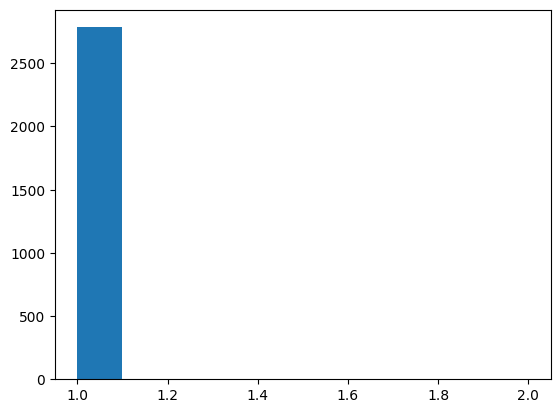

In [30]:
plt.hist(labeled_events.concurrency)

## Save events to disk

In [31]:
labeled_events.to_pickle(DIRECTION_LABEL_FILE_PATH)